```yaml
#%mldev nb_context

pipeline:
  - imports
  - lin_model
  - mixture
  - print_sigma
  - plot
  - plot_2
  - x_servo
  - mixture_2
  - params
  - print_sigmas_2
  - Pearson
  - fig_3
  - plt_1
  - plt_final

```

In [1]:
!git clone https://github.com/andriygav/MixtureLib.git
!python3 -m pip install MixtureLib/src/.

from mixturelib.local_models import EachModelLinear
from mixturelib.hyper_models import HyperExpertNN, HyperModelDirichlet
from mixturelib.mixture import MixtureEM

import matplotlib.pyplot as plt
from matplotlib import gridspec
import pylab
from sklearn import metrics

from tqdm import tqdm_notebook as tqdm
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

#%mldev imports

Cloning into 'MixtureLib'...
remote: Enumerating objects: 1595, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 1595 (delta 69), reused 101 (delta 51), pack-reused 1441
Receiving objects: 100% (1595/1595), 9.06 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (882/882), done.
Processing ./MixtureLib/src
  Created wheel for mixturelib: filename=mixturelib-0.4.0-cp37-none-any.whl size=13739 sha256=1f0f94072d89a5a2c56b3e4654279faa40844114ec09b6f8e9a0ca4972e31aa1
  Stored in directory: /tmp/pip-ephem-wheel-cache-n89bxtwq/wheels/8f/0e/0e/7b633cbf34c93d96d5b40677655ae6cda78087b2231b3cb1dc
Successfully built mixturelib


device(type='cpu')

### Линейная модель

In [2]:
def f_1(x):
    return 10*x[0] + np.random.randn()

def f_2(x):
    return 50*x[0] + np.random.randn()

def cor_Pearson(a, b):
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    first_sum = 0
    second_sum = 0
    third_sum = 0
    for i in range(len(a)):
        first_sum += (float(a[i]) - float(a_mean))*(float(b[i]) - float(b_mean))
        second_sum += (float(a[i]) - float(a_mean))**2
        third_sum += (float(b[i]) - float(b_mean))**2
    return first_sum/(second_sum*third_sum)**(0.5)

N = 200
n = 2
nn = 200

errors = []
correlations = []
sigmas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,
          1.0]

#%mldev lin_model

In [3]:
torch.random.manual_seed(42)
first_model = EachModelLinear(input_dim=2)
second_model = EachModelLinear(input_dim=2)

list_of_models = [first_model, second_model]

HpMd = HyperExpertNN(input_dim=2, hidden_dim=5,output_dim=2, epochs=1000)

mixture = MixtureEM(HyperParameters={'beta': 1.},
                    HyperModel=HpMd,
                    ListOfModels=list_of_models,
                    model_type='sample')

#%mldev mixture

In [4]:
for i, sigma in enumerate(sigmas):
    #порождение данных
    x1 = np.random.normal(0, 1, (200, 1))
    x2 = np.random.normal(0, 1, (200, 1))
    y1 = np.array([f_1(x) for x in x1])
    y2 = np.array([f_2(x) for x in x2])
    s1 = np.random.normal(0, sigma, 200).reshape((200, 1))
    s2 = np.random.normal(0, sigma, 200).reshape((200, 1))
    X1 = np.hstack([x1, s1]) 
    X2 = np.hstack([s2, x2])
    X = np.vstack([X1, X2])
    Y = np.hstack([y1, y2])
    real_second_w = np.array([[10.], [0.]])
    real_first_w = np.array([[0.], [50.]])
    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])
    #обучение модели
    torch.random.manual_seed(42)
    mixture.fit(X_tr, Y_tr)
    predicted_first_w = mixture.ListOfModels[0].W.numpy()
    predicted_second_w = mixture.ListOfModels[1].W.numpy()
    weights = []
    weights.append([predicted_first_w[0][0], predicted_first_w[1][0]])
    weights.append([predicted_second_w[0][0], predicted_second_w[1][0]])
    #расчет расстояния между оптимальными локальными моделями, ошибка ансамбля
    Y1 = X.dot(weights[0])
    Y2 = X.dot(weights[1])
    correlations.append(cor_Pearson(Y1, Y2))
    pi = mixture.HyperModel.PredictPi(X_tr, None)
    #общая ошибка ансамбля
    er = torch.cat([pi[:, k].view([-1,1])*(Y_tr - local_model(X_tr))**2 for k, local_model in enumerate(mixture.ListOfModels)], dim=1).sum()
    errors.append(float(er))
    print(sigma, cor_Pearson(Y1, Y2), float(er))

#%mldev print_sigma

0.0 0.9999797560975168 449.89508056640625
0.1 0.9997428379105414 5901.6328125
0.2 0.9988373938267215 22543.4375
0.3 0.9975796678230887 44202.29296875
0.4 0.040789252317385456 69350.53125
0.5 -0.03439497757244784 94684.609375
0.6 0.012693539266348313 154981.5
0.7 0.093190846640711 237208.09375
0.8 0.05497775837669153 374954.375
0.9 0.01259706258343038 433359.125
1.0 -0.0710211642016051 477610.8125


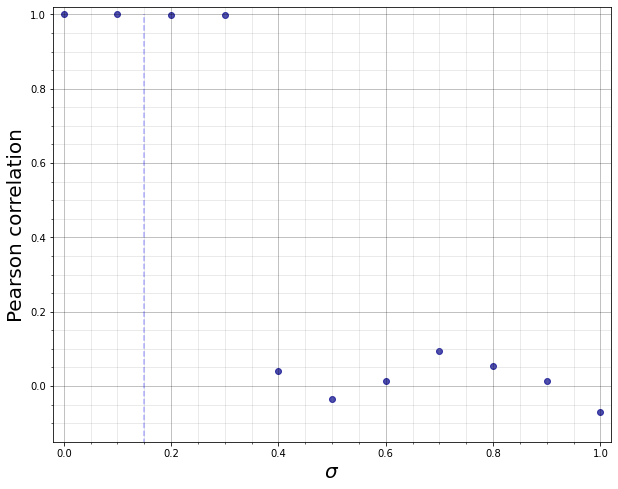

In [5]:
#график зависимости расстояния от параметра шума
fig = plt.figure(figsize=(10,8))   

plt.scatter(sigmas, correlations, color='darkblue', alpha=0.7)  

print (fig.axes)
plt.xlabel('$\sigma$', fontsize=20)
plt.ylabel('Pearson correlation', fontsize=20)
plt.plot(np.full(13, 0.15), np.arange(-0.2, 1.1, 0.1), 'b--', alpha=0.3)
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.15, 1.02])
pylab.savefig('Pearson_cor_sigma_for_linear_models.pdf')
plt.show()

#%mldev plot

No handles with labels found to put in legend.


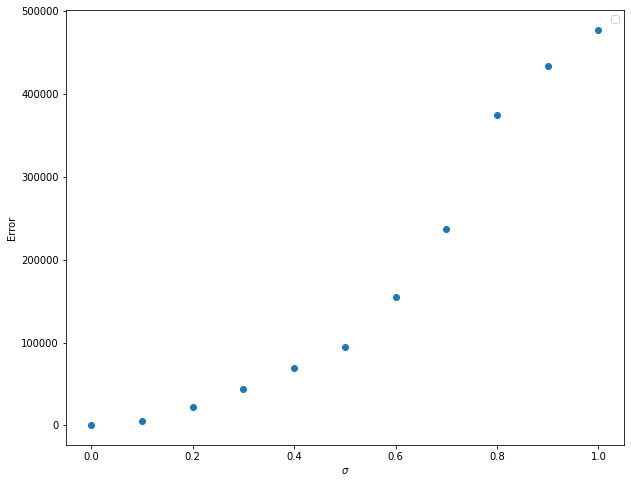

In [6]:
fig = plt.figure(figsize=(10,8))

plt.scatter(sigmas, errors)  

print (fig.axes)
plt.legend(loc='best')
plt.xlabel('$\sigma$')
plt.ylabel('Error')



pylab.savefig('Errors_sigma_for_linear.pdf')
plt.show()

#%mldev plot_2

###Boston and Servo

In [7]:
from sklearn.datasets import load_boston
import pandas as pd  
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
X_boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names).values
y_boston = boston['MEDV'] = boston_dataset.target
#Servo
def LoadData(url = "https://raw.githubusercontent.com/ttgadaev/SampleSizeEstimation/master/datasets/servo.csv",
             path = None):
    """
    return X, y
    """
    if path is not None:
        if os.path.exists(path):
            data = pd.read_csv(path, header=0)
        else:
            data = pd.read_csv(url, header=0)
            data.to_csv(path, header=True, index=False)
    else:
        data = pd.read_csv(url, header=0)

    y = data['answer'].values
    del data['answer']
    X = data.values
    return X, y

X_servo, y_servo = LoadData(url = "https://raw.githubusercontent.com/ttgadaev/SampleSizeEstimation/master/datasets/servo.csv")

X_servo[np.where(X_servo == 'A')] = 1
X_servo[np.where(X_servo == 'B')] = 2
X_servo[np.where(X_servo == 'C')] = 3
X_servo[np.where(X_servo == 'D')] = 4
X_servo[np.where(X_servo == 'E')] = 5
X_servo = np.array(X_servo, dtype = np.float64)

#%mldev x_servo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [8]:
torch.random.manual_seed(42)
first_model = EachModelLinear(input_dim=13)
second_model = EachModelLinear(input_dim=13)

list_of_models = [first_model, second_model]
HpMd = HyperExpertNN(input_dim=13, hidden_dim=5,output_dim=2, epochs=1000)
mixture = MixtureEM(HyperParameters={'beta': 1.},
                    HyperModel=HpMd,
                    ListOfModels=list_of_models,
                    model_type='sample')

#%mldev mixture_2

In [9]:
sigmas1 = sigmas
correlations1 = []
errors1 = []
errors_model1 = []
errors_model2 = []

#%mldev params

In [10]:
for i, sigma in enumerate(sigmas1):
    #Порождение данных
    X1 = X_boston
    X1 = scale(X1)
    X2 = X_servo
    s = np.zeros((167, 9))
    for i in range(9):
        s[:,i] = np.random.normal(0, sigma, 167)
    X2 = np.hstack([X2, s])
    X2 = scale(X2)
    X = np.vstack([X1, X2])
    Y = np.hstack([y_boston, y_servo])
    X = scale(X)
    Y = scale(Y)
    torch.random.manual_seed(42)
    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])
    #print(X_tr.shape, Y_tr.shape)
    #Обучение ансамбля
    torch.random.manual_seed(42)
    mixture.fit(X_tr, Y_tr)
    predict_1 = []
    predict_2 = []    
    for i in range(13):
        predict_1.append(mixture.ListOfModels[0].W[i][0])
    predict_1 = np.array(predict_1)
    for i in range(13):
        predict_2.append(mixture.ListOfModels[1].W[i][0])
    predict_2 = np.array(predict_2)
    #----------distance between local models---------------
    temp = []
    Y1 = X.dot(predict_1)
    Y2 = X.dot(predict_2)
    pi = mixture.HyperModel.PredictPi(X_tr, None)
    er = torch.cat([pi[:, k].view([-1,1])*(Y_tr - local_model(X_tr))**2 for k, local_model in enumerate(mixture.ListOfModels)], dim=1).sum()
    local_model = mixture.ListOfModels[0]
    er1 = torch.cat([pi[:, 0].view([-1,1])*(Y_tr - local_model(X_tr))**2], dim=1).sum()
    local_model = mixture.ListOfModels[1]
    er2 = torch.cat([pi[:, 1].view([-1,1])*(Y_tr - local_model(X_tr))**2], dim=1).sum()
    errors1.append(float(er))
    errors_model1.append(float(er1))
    errors_model2.append(float(er2))
    correlations1.append(cor_Pearson(Y1, Y2))
    print(sigma, cor_Pearson(Y1, Y2), float(er))

#%mldev print_sigmas_2

0.0 -0.018896423350371803 246.09109497070312
0.1 -0.029602189428487562 267.9654846191406
0.2 0.06712859839266606 313.011962890625
0.3 -0.15409172474082902 274.060546875
0.4 -0.07940189132927282 285.8254089355469
0.5 0.011745936846859505 277.84442138671875
0.6 0.017289247165885906 303.0290832519531
0.7 0.01669702606894633 282.7969970703125
0.8 -0.09254145905288706 297.6918029785156
0.9 -0.24147999395510486 284.24383544921875
1.0 -0.16428412111846097 262.1064453125


No handles with labels found to put in legend.


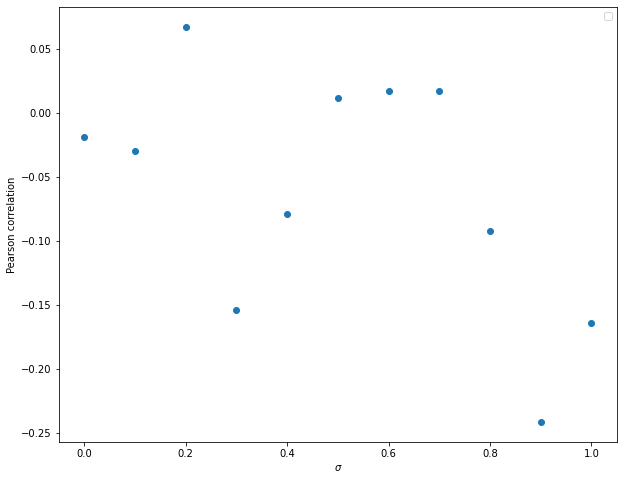

In [11]:
fig = plt.figure(figsize=(10,8))   
plt.scatter(sigmas1, correlations1)  

# После нанесения графического элемента в виде маркера
# список текущих областей состоит из одной области
print (fig.axes)
plt.legend(loc='best')
plt.xlabel('$\sigma$')
plt.ylabel('Pearson correlation')
# смотри преамбулу


pylab.savefig('Pearson_cor_sigma.pdf')
plt.show()

#%mldev Pearson

No handles with labels found to put in legend.


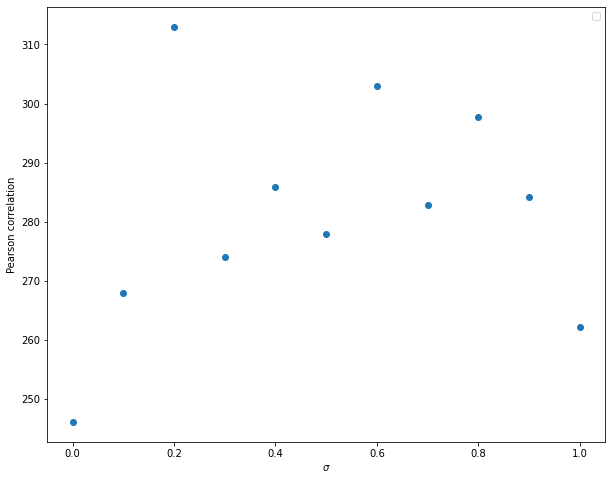

In [12]:
fig = plt.figure(figsize=(10,8))   
plt.scatter(sigmas1, errors1)  

# После нанесения графического элемента в виде маркера
# список текущих областей состоит из одной области
print (fig.axes)
plt.legend(loc='best')
plt.xlabel('$\sigma$')
plt.ylabel('Pearson correlation')
# смотри преамбулу


pylab.savefig('Ensemble_errors_sigma.pdf')
plt.show()

#%mldev fig_3

No handles with labels found to put in legend.


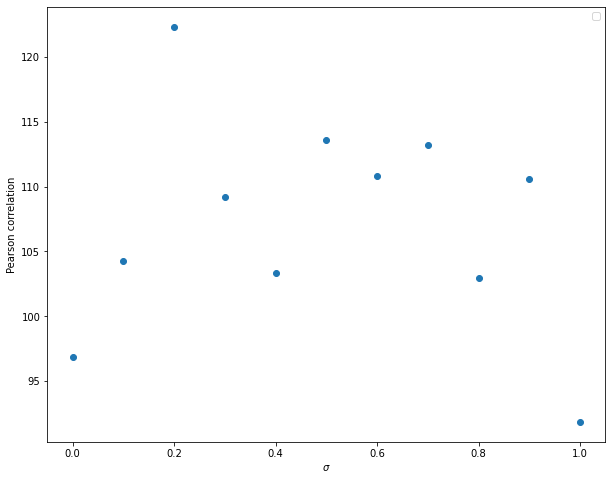

In [13]:
fig = plt.figure(figsize=(10,8))   
plt.scatter(sigmas1, errors_model1)  

# После нанесения графического элемента в виде маркера
# список текущих областей состоит из одной области
print (fig.axes)
plt.legend(loc='best')
plt.xlabel('$\sigma$')
plt.ylabel('Pearson correlation')
# смотри преамбулу


pylab.savefig('Ensemble_errors_model1_sigma.pdf')
plt.show()

#%mldev plt_1

No handles with labels found to put in legend.


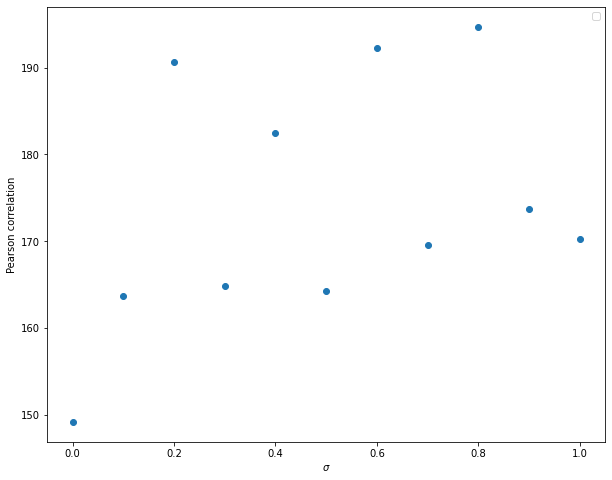

In [14]:
fig = plt.figure(figsize=(10,8))   
plt.scatter(sigmas1, errors_model2)  

# После нанесения графического элемента в виде маркера
# список текущих областей состоит из одной области
print (fig.axes)
plt.legend(loc='best')
plt.xlabel('$\sigma$')
plt.ylabel('Pearson correlation')
# смотри преамбулу


pylab.savefig('Ensemble_errors_model2_sigma.pdf')
plt.show()

#%mldev plt_final